In [7]:
# coding=utf-8

# Author: Alceu Britto
#

!pip install deslib

import matplotlib.pyplot as plt
import matplotlib as pl
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import get_cmap
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from deslib.util.datasets import make_P2
from sklearn.model_selection import GridSearchCV
from sklearn import manifold, datasets
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits, load_breast_cancer, load_iris
import itertools
import pandas as pd
import seaborn as sns
import urllib
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [8]:
# Plotting the confusion matrix 
def plot_confusion_matrix(ax, cm, title=None):

    df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
    sns.heatmap(df_cm, annot=True)
    ax.set_title('Confusion Matrix --> ' + title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return ax

In [9]:
# Plotting-related functions
def make_grid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


In [10]:
# Plotting the Classifier Decision

def plot_classifier_decision(ax, clf, X, X_embedded, mode='line', **params):
 
# create meshgrid
    resolution = 200 # 100x100 background pixels
    y_predicted = clf.predict(X);
    X2d_xmin, X2d_xmax = np.min(X_embedded[:,0]), np.max(X_embedded[:,0])
    X2d_ymin, X2d_ymax = np.min(X_embedded[:,1]), np.max(X_embedded[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_embedded, y_predicted) 
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
    ax.contourf(xx, yy, voronoiBackground, levels=10, cmap="RdBu_r")
    plot_dataset(X_embedded, y_predicted, ax, 'teste', **params)

    return ax
  

In [11]:
# Plotting the dataset

def plot_dataset(X, y, ax=None, title=None, **params):

    X_t=pd.DataFrame(X)
    y=pd.DataFrame(y)
    XY=pd.concat([X_t,y], axis=1)
    XY.columns = ['x', 'y', 'digit']

    customPalette=sns.hls_palette(10, l=.7, s=1)

    ax.set_xlim(XY['x'].min()*0.98,XY['x'].max()*1.02)
    ax.set_ylim(XY['y'].min()*0.98,XY['y'].max()*1.02)

    for i in range(0,10):
        k=0
        for l, row in XY.loc[XY['digit']==i,:].iterrows():
            if k==0: 
                ax.plot(row['x'], row['y'], '.', color=customPalette[i], label=int(row['digit']))
                ax.legend(numpoints=1, markerscale=3, loc='upper right', bbox_to_anchor=(1.2, 1.0))
                k += 1    
            ax.annotate(int(row['digit']), (row['x'], row['y']), horizontalalignment='center', verticalalignment='center', size=10, color=customPalette[i])
            ax.set_title(title, fontsize=15)
            
    return ax

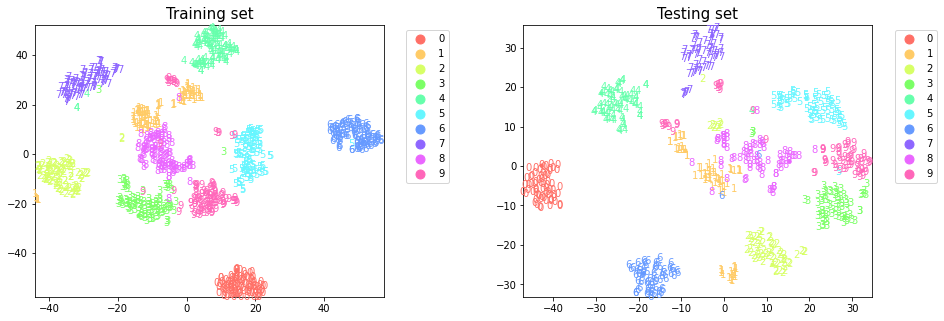

In [12]:
# Loading datasets
rng = np.random.RandomState(123)

X,y=load_digits(return_X_y=True)

# EXEMPLO USANDO HOLDOUT
# Holdout -> dividindo a base em treinamento (60%) e teste (40%), estratificada
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4, random_state=42, stratify=y)

X_Embedded_train=X_train
X_Embedded=X_test

X_Embedded_train = TSNE(n_components=2).fit_transform(X_train)
X_Embedded = TSNE(n_components=2).fit_transform(X_test) 

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plot_dataset(X_Embedded_train, y_train, ax=axs[0], title='Training set')
plot_dataset(X_Embedded, y_test, ax=axs[1], title='Testing set')

In [13]:
# Define single classifiers (monolithic Classifiers)

dt =  DecisionTreeClassifier(criterion='entropy')
knn = KNeighborsClassifier(n_neighbors=3)
knnw = KNeighborsClassifier(n_neighbors=3, weights='distance')
mlp = MLPClassifier(solver='lbfgs', early_stopping=True, hidden_layer_sizes=(32), activation='logistic', batch_size=100, max_iter=10000, learning_rate_init=0.001, momentum=0.8, random_state=46)
nb = GaussianNB(var_smoothing=1e-09)

# parameters for SVM
parameters = [
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'kernel': ['poly']},
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
]
svm = SVC(gamma='scale', probability=True, random_state=42)
svm = GridSearchCV(svm, parameters, scoring = 'accuracy', cv=10)

# Define ensembles (homogeneous and heterogeneous)
rf = RandomForestClassifier(n_estimators=100, random_state=0)
cb = VotingClassifier(estimators=[('DecisionTree', dt), ('NaiveBayes', nb)], voting='soft')
bg = BaggingClassifier(base_estimator=dt, n_estimators=100, random_state=0)
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
xgboost = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

titles = ['DecisionTree', 'KNN', 'KNN_W', 'NaiveBayes', 'MLP', 'SVM', 'RF', 'DT+NB', 'Bag', 'Ada', 'XGBoost']
methods = [dt, knn, knnw, nb, mlp, svm, rf, cb, bg, ada, xgboost]




In [14]:
# Fit the classifiers
scores = []
for method, name in zip(methods, titles):
    method.fit(X_train, y_train)
    scores.append(method.score(X_test, y_test))
    print("Classification accuracy {} = {}"
          .format(name, method.score(X_test, y_test)))
    

Classification accuracy DecisionTree = 0.8344923504867872
Classification accuracy KNN = 0.9833101529902643
Classification accuracy KNN_W = 0.9833101529902643
Classification accuracy NaiveBayes = 0.8247566063977747
Classification accuracy MLP = 0.9415855354659249
Classification accuracy SVM = 0.9874826147426982
Classification accuracy RF = 0.9666203059805285
Classification accuracy DT+NB = 0.8581363004172462
Classification accuracy Bag = 0.9388038942976356
Classification accuracy Ada = 0.5924895688456189
Classification accuracy XGBoost = 0.9401947148817803


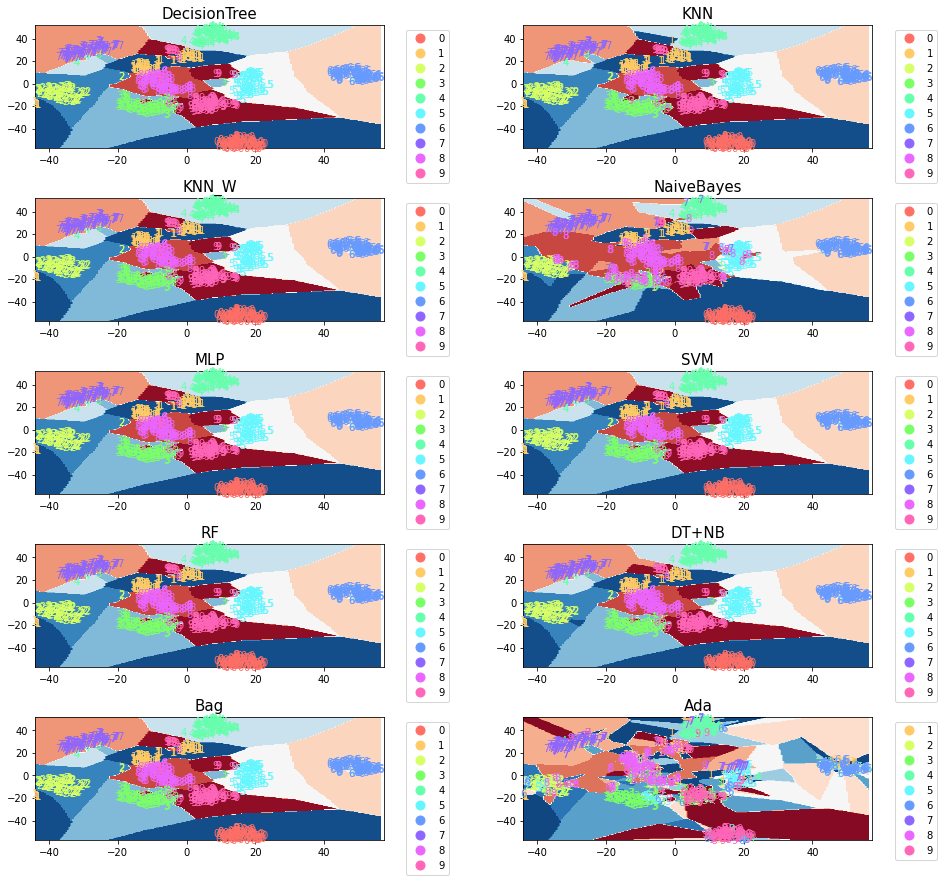

<Figure size 432x288 with 0 Axes>

In [15]:
# Plotting the Decision Border of the Classifiers.
fig2, sub = plt.subplots(5, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for clf, ax, title in zip(methods, sub.flatten(), titles):
    plot_classifier_decision(ax, clf, X_train, X_Embedded_train, mode='filled', alpha=0.4)
    ax.set_title(title, fontsize=15)

plt.show()
plt.tight_layout()    

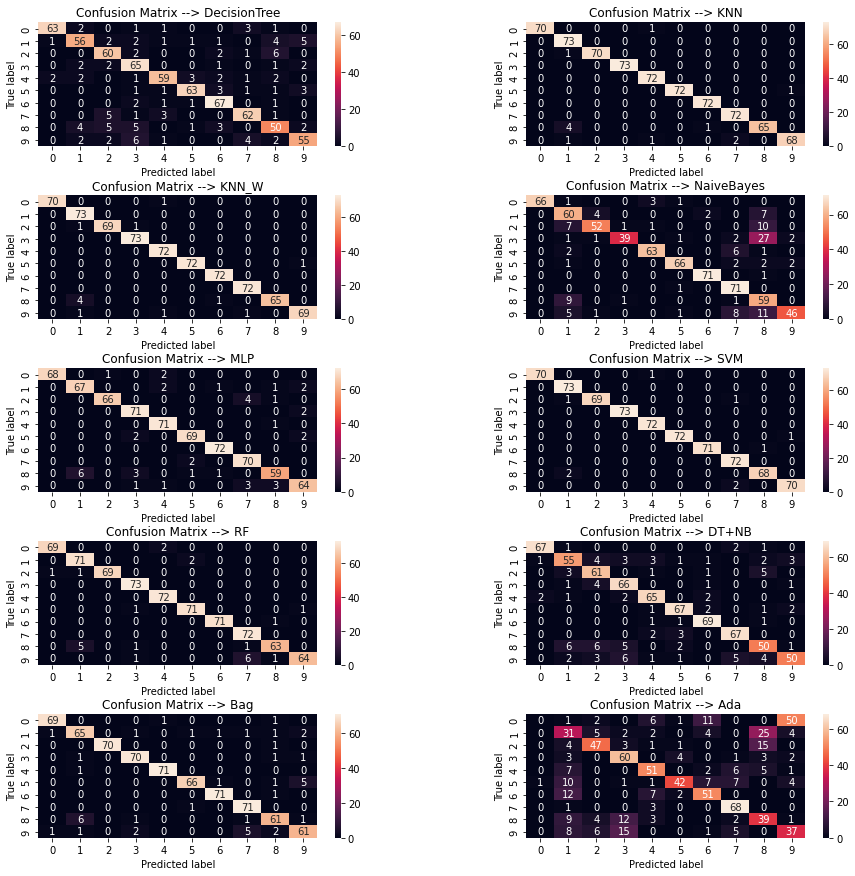

<Figure size 432x288 with 0 Axes>

In [16]:
# Plotting the Confusion Matrix
fig3, sub1 = plt.subplots(5, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
for clf, ax, title in zip(methods, sub1.flatten(), titles):
    y_predicted = clf.predict(X_test)
    cm = confusion_matrix(y_test , y_predicted)
    #plot_confusion_matrix(ax, cm, title)
    df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
    sns.heatmap(df_cm, annot=True, ax=ax)
    ax.set_title('Confusion Matrix --> ' + title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

plt.show()
plt.tight_layout()    

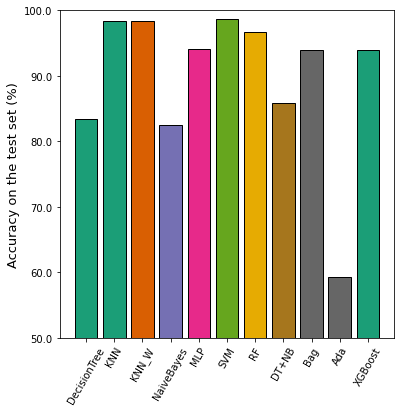

In [17]:
###############################################################################
# Plotting the results
# -----------------------
# Let's now evaluate the methods on the test set.
#
cmap = get_cmap('Dark2')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
fig, ax = plt.subplots(figsize=(6, 6.5))
pct_formatter = FuncFormatter(lambda x, pos: '{:.1f}'.format(x * 100))
ax.bar(np.arange(len(methods)),
       scores,
       color=colors,
       tick_label=titles,
       edgecolor='k')

ax.set_ylim(0.50, 1.00)
ax.set_ylabel('Accuracy on the test set (%)', fontsize=13)
ax.yaxis.set_major_formatter(pct_formatter)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
plt.subplots_adjust(bottom=0.18)
plt.show()